In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import f1_score

# Part 1: Image Preprocessing

Load the images using appropriate libraries and display them with a brief description of
their content.

In [ ]:
images=[]
desc=["A train running in a city","A bright yellow pinwheel","A beautiful chamleon","Green leaves on corner","A small white car running on a asphalt road","A beautiful butterfly with flowers in background","A girl wearing a hat","A scene of river with sunset increasing its beauty","A colorful bird with blurred background","A blue frog with blurred background"]
root_path="/content/drive/MyDrive/PBV_PHOTOS/"
for i in range(1,11):
  images.append(root_path+str(i)+".jpg")
k=1
for image in images:
  images[k-1]=cv2.imread(image)
  img1 = Image.open(image)
  width, height = img1.size
  print(desc[k-1])
  print("width :", width, "px, height :", height, "px")
  plt.imshow(img1)
  plt.title("Original Image "+str(k))
  plt.axis('off')
  plt.show()
  k+=1

Convert each image to grayscale using techniques that ensure optimal contrast
enhancement and dynamic range preservation.

In [ ]:
def grayscale_conversion(image,image_number):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  gray_image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  clahe_image = clahe.apply(gray_image)
  gamma = 1.1
  gamma_corrected_img = np.uint8(np.power(gray_image / 255.0, gamma) * 255)
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))

  axes[0].imshow(image,cmap="gray")
  axes[0].set_title("Original Image "+str(image_number))

  axes[1].imshow(gray_image, cmap="gray")
  axes[1].set_title("Gray Image "+str(image_number))

  axes[2].imshow(clahe_image, cmap="gray")
  axes[2].set_title("Image "+str(image_number)+" with CLAHE")

  axes[3].imshow(gamma_corrected_img, cmap="gray")
  axes[3].set_title("Gamma Corrected Image "+str(image_number))

  return gray_image, clahe_image , gamma_corrected_img

In [ ]:
img_num=1
gray_images=[]
clahe_images=[]
gamma_corrected_images=[]
for image in images:
  a,b,c=grayscale_conversion(image,img_num)
  img_num+=1
  gray_images.append(a)
  clahe_images.append(b)
  gamma_corrected_images.append(c)


#Part 2: Complex Orientation Filters

Select one high-resolution grayscale image from Part 1 for further processing.

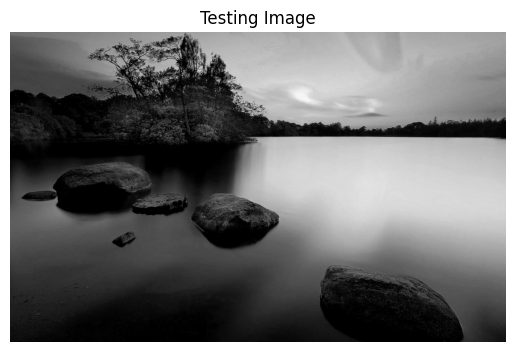

In [ ]:
img_high_reso=None
highest_reso=0
for image in gamma_corrected_images:
  # print(image.size)
  if(image.size>highest_reso):
    highest_reso=image.size
    img_high_reso=image

testing_image=img_high_reso
plt.imshow(testing_image,cmap="gray")
plt.title("Testing Image" )
plt.axis('off')
plt.show()

Implement complex orientation filters based on Gabor wavelets. Create multiple filters (at
least 4, at 0, 45, 90 and 135 degrees respectively) with varying orientations and
frequencies.

In [ ]:
# Function to create a Gabor filter
def create_gabor_filter(orientation, frequency):
    return cv2.getGaborKernel(ksize=(9, 9), sigma=2.0, theta=np.deg2rad(orientation), lambd=frequency, gamma=1.1, psi=0, ktype=cv2.CV_32F)

In [ ]:
orientations=[0,30,45,60,90,120,135,150]
frequencies = [2.1,2.6,3.7,4.5,5.5]

In [ ]:
gabor_filters = {}
for degree in orientations:
    for f in frequencies:
        gabor_filters[(degree, f)] = create_gabor_filter(degree,f)
        gabor_filters[(degree, f)] /= gabor_filters[(degree, f)].sum()

Apply each filter to the selected grayscale image using convolution operations.

In [ ]:
filtered_images = {}
for degree in orientations:
    for f in frequencies:
        filtered_images[(degree,f)]=cv2.filter2D(testing_image, cv2.CV_8U, gabor_filters[(degree, f)])

Visualize the filtered images for each orientation, emphasizing the extracted features.

In [ ]:
fig, axes = plt.subplots(len(orientations), len(frequencies), figsize=(20, 20))
for i in range(len(orientations)):
    for j in range(len(frequencies)):
        filter_img=filtered_images[(orientations[i],frequencies[j])]
        axes[i, j].imshow(filter_img, cmap='gray')
        axes[i, j].set_title(f"Orientation: {orientations[i]}°, Frequency: {frequencies[j]}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

#Part 3: Winner-Takes-All and Normalization

Implement a Winner-Takes-All (WTA) algorithm that considers both magnitude and
orientation of the complex filtered images.

In [ ]:
# Function to perform Winner-Takes-All (WTA) selection
def winner_takes_all(filtered_imgs):
    winning_image = None
    winning_score = -1
    for image in filtered_imgs:
        magnitude = np.abs(image)
        orientation = np.angle(image)
        score = magnitude * (1 + np.cos(2 * orientation))
        if np.max(score) > np.max(winning_score):
            winning_score = score
            winning_image = image

    return winning_image

Normalize the WTA output images to enhance feature visibility while preserving
contextual relationships.

In [ ]:
def acn_normalisation(img):
  result_image = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10)).apply(img)
  return result_image

In [ ]:
filtered_list_img=np.array(list(filtered_images.values()))
wta_image=winner_takes_all(filtered_list_img)

In [ ]:
wta_image_normalise=acn_normalisation(wta_image.astype(np.uint8))

Visualize the WTA and normalized images, capturing intricate features and texture
patterns.

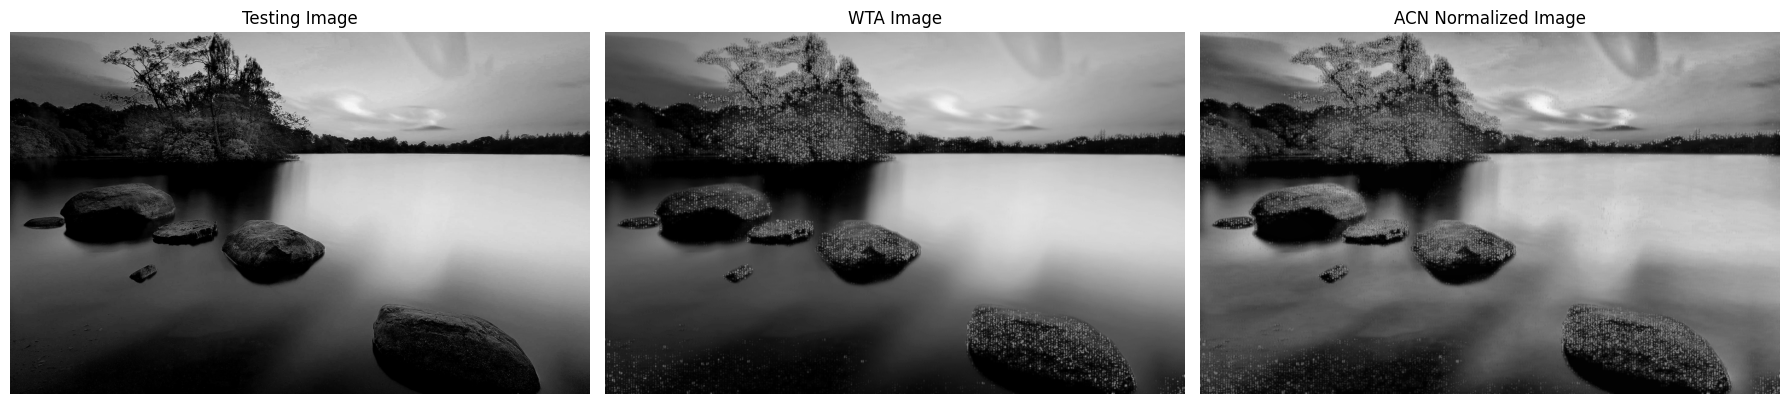

In [ ]:
plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plt.imshow(testing_image, cmap='gray')
plt.title("Testing Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wta_image.astype(np.uint8), cmap='gray')
plt.title("WTA Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wta_image_normalise, cmap='gray')
plt.title("ACN Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

#Part 4: Comparative Analysis

Apply the entire pipeline (image preprocessing, complex orientation filtering, WTA, and
normalization) to all loaded images.

In [ ]:
def pipeline(images_list):
    k=1
    edge_detected_image=[]
    for image in images_list:
      gray_image, clahe_image , gamma_corrected_img = grayscale_conversion(image,k)
      orientations=[0,30,45,60,90,120,135,150,160,180]
      frequencies = [2.1,2.6,3.7,4.5,5.5]
      gabor_filters = {}
      for degree in orientations:
        for f in frequencies:
          gabor_filters[(degree, f)] = create_gabor_filter(degree,f)
          gabor_filters[(degree, f)] /= gabor_filters[(degree, f)].sum()
      filtered_images = {}
      for degree in orientations:
        for f in frequencies:
          filtered_images[(degree,f)]=cv2.filter2D(gamma_corrected_img, cv2.CV_8U, gabor_filters[(degree, f)])
      wta_image= winner_takes_all(np.array(list(filtered_images.values())))
      wta_normalised_image = acn_normalisation(wta_image.astype(np.uint8))
      edge_detected_image.append(wta_normalised_image)
      plt.figure(figsize=(15, 5))
      plt.subplot(1, 3, 1)
      plt.imshow(gamma_corrected_img, cmap='gray')
      plt.title("Testing Image")
      plt.axis('off')

      plt.subplot(1, 3, 2)
      plt.imshow(wta_image.astype(np.uint8), cmap='gray')
      plt.title("WTA Image")
      plt.axis('off')

      plt.subplot(1, 3, 3)
      plt.imshow(wta_normalised_image , cmap='gray')
      plt.title("ACN Normalized Image")
      plt.axis('off')

      plt.tight_layout()
      plt.show()
      k+=1
    return edge_detected_image

In [ ]:
original_edge_detected_images=pipeline(images)

Compare and analyze the results across different images, focusing on the impact of
complexity, texture, and lighting on edge detection.

In [ ]:
original_gray_scale_images=gamma_corrected_images
def edge_f1_score(ground_truth_edges, detected_edges,threshold=128):
    ground_truth_edges = (ground_truth_edges > threshold).astype(np.uint8)
    detected_edges = (detected_edges > threshold).astype(np.uint8)
    ground_truth_edges = ground_truth_edges.flatten()
    detected_edges = detected_edges.flatten()
    score = f1_score(ground_truth_edges, detected_edges)
    return score

In [ ]:
#SSIM
for i in range(len(original_gray_scale_images)):
  ssim_value = ssim(original_gray_scale_images[i],original_edge_detected_images[i])
  print(f'SSIM score for image {i+1}: {ssim_value}')

SSIM score for image 1: 0.22383628990889223
SSIM score for image 2: 0.1969667465944559
SSIM score for image 3: 0.1352731537089994
SSIM score for image 4: 0.3101763100217681
SSIM score for image 5: 0.2579973989262218
SSIM score for image 6: 0.13482777840255863
SSIM score for image 7: 0.12393860725175722
SSIM score for image 8: 0.24737000014531826
SSIM score for image 9: 0.3446641274985803
SSIM score for image 10: 0.225634882845303


In [ ]:
#Edge f1 score
for i in range(len(original_gray_scale_images)):
  f1 = edge_f1_score(original_gray_scale_images[i],original_edge_detected_images[i])
  print(f'Edge f1 score for image {i+1}: {f1}')

Edge f1 score for image 1: 0.8077341603416851
Edge f1 score for image 2: 0.588753716988196
Edge f1 score for image 3: 0.4293732884477857
Edge f1 score for image 4: 0.9312451137455944
Edge f1 score for image 5: 0.7137830268412999
Edge f1 score for image 6: 0.4426259402780944
Edge f1 score for image 7: 0.7109559503029058
Edge f1 score for image 8: 0.8469974476201162
Edge f1 score for image 9: 0.638402099970423
Edge f1 score for image 10: 0.7376361394004618


Apply different kinds of noise eg gaussian noise, motion blur etc on the image and then
perform edge detection.

In [ ]:
gaussian_noised_images=[]
motion_blurred_images=[]
k=1
for image in images:
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  mean = 0
  stddev = 20
  gaussian_noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
  noisy_image = cv2.add(image, gaussian_noise)
  gaussian_noised_images.append(noisy_image)


for image in images:
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  kernel_size = 12
  kernel = np.zeros((kernel_size, kernel_size))
  kernel[int((kernel_size-1)/2), :] = 1
  kernel /= kernel_size
  motion_blurred_image = cv2.filter2D(image, -1, kernel)
  motion_blurred_images.append(motion_blurred_image)
  motion_blurred_image=cv2.cvtColor(motion_blurred_image, cv2.COLOR_BGR2RGB)

for image in images:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  axes[0].imshow(image)
  axes[0].set_title("Original Image "+str(k))

  axes[1].imshow(cv2.cvtColor(gaussian_noised_images[k-1],cv2.COLOR_BGR2RGB), cmap="gray")
  axes[1].set_title("Gaussian Noise Image "+str(k))

  axes[2].imshow(cv2.cvtColor(motion_blurred_images[k-1],cv2.COLOR_BGR2RGB), cmap="gray")
  axes[2].set_title("Motion Blurred Image "+str(k))
  k+=1

In [ ]:
gaussian_noise_edge_detected_images=pipeline(gaussian_noised_images)

In [ ]:
motion_blurred_edge_detected_images=pipeline(motion_blurred_images)

Do a comparison between the original edge detection and noise influenced edge
detection using metrics such as structural similarity index (SSIM) and edge F1-score.

Gaussian Noise vs Original

In [ ]:
## SSIM
for i in range(len(original_edge_detected_images)):
  ssim_value = ssim(original_edge_detected_images[i],gaussian_noise_edge_detected_images[i])
  print(f'SSIM score for image {i+1}: {ssim_value}')

SSIM score for image 1: 0.08655252382368901
SSIM score for image 2: 0.010983297077169992
SSIM score for image 3: 0.025353708667450504
SSIM score for image 4: 0.053537898854808
SSIM score for image 5: 0.05669750581429413
SSIM score for image 6: 0.02930050893797888
SSIM score for image 7: 0.030949988840858724
SSIM score for image 8: 0.014496829197991397
SSIM score for image 9: 0.010109387196246917
SSIM score for image 10: 0.029713778349899706


In [ ]:
## Edge F1-Score
for i in range(len(original_edge_detected_images)):
    f1 = edge_f1_score(original_edge_detected_images[i], gaussian_noise_edge_detected_images[i])
    print(f"Edge F1-Score for Image {i+1} is: {f1}")

Edge F1-Score for Image 1 is: 0.6985971367263667
Edge F1-Score for Image 2 is: 0.41467569089254785
Edge F1-Score for Image 3 is: 0.46513064971751406
Edge F1-Score for Image 4 is: 0.8867854152205972
Edge F1-Score for Image 5 is: 0.5687101370282184
Edge F1-Score for Image 6 is: 0.3907767133208896
Edge F1-Score for Image 7 is: 0.5552403610409893
Edge F1-Score for Image 8 is: 0.530454476904035
Edge F1-Score for Image 9 is: 0.4559820579713578
Edge F1-Score for Image 10 is: 0.5398240080308011


Motion Blurred vs Original

In [ ]:
## SSIM
for i in range(len(original_edge_detected_images)):
  ssim_value = ssim(original_edge_detected_images[i],motion_blurred_edge_detected_images[i])
  print(f'SSIM score for {i+1}th image: {ssim_value}')

SSIM score for 1th image: 0.1708437322293673
SSIM score for 2th image: 0.1947058048469566
SSIM score for 3th image: 0.14086088044531112
SSIM score for 4th image: 0.2827124034289408
SSIM score for 5th image: 0.25123393495145974
SSIM score for 6th image: 0.22773171174073475
SSIM score for 7th image: 0.15679968782345233
SSIM score for 8th image: 0.23539738892665088
SSIM score for 9th image: 0.3040494719029552
SSIM score for 10th image: 0.21276454605874157


In [ ]:
#Edge f1 score
for i in range(len(original_edge_detected_images)):
    f1 = edge_f1_score(original_edge_detected_images[i], motion_blurred_edge_detected_images[i])
    print(f"Edge F1-Score for Image: {i+1} is {f1}")

Edge F1-Score for Image: 1 is 0.8081415519833468
Edge F1-Score for Image: 2 is 0.7947110141766631
Edge F1-Score for Image: 3 is 0.67562151223401
Edge F1-Score for Image: 4 is 0.934922429055845
Edge F1-Score for Image: 5 is 0.7781359740453384
Edge F1-Score for Image: 6 is 0.6455561422034495
Edge F1-Score for Image: 7 is 0.7547223790119924
Edge F1-Score for Image: 8 is 0.8574197607777312
Edge F1-Score for Image: 9 is 0.7223981466149493
Edge F1-Score for Image: 10 is 0.8261803576677048


#Part 5: Visualization

Implement visualization techniques to highlight detected edges and features on the original images.Generate gradient magnitude and orientation maps for visualizing the underlying features.

In [ ]:
def visualisation(original_gray_images, edge_detected_images):
    k=1
    for i in range(len(original_gray_images)):
      edges = abs(original_gray_images[i] - edge_detected_images[i])

      sobel_x_comp = cv2.Sobel(original_gray_images[i], cv2.CV_64F, 1, 0, ksize = 3)
      sobel_y_comp = cv2.Sobel(original_gray_images[i], cv2.CV_64F, 0, 1, ksize = 3)

      vect_grad_magnitudes = np.sqrt(sobel_x_comp ** 2, sobel_y_comp ** 2)

      vect_grad_orientations = np.arctan2(sobel_y_comp, sobel_x_comp)
      orientation_map = (vect_grad_orientations + np.pi) / (2 * np.pi)
      orientation_map = cv2.cvtColor(np.uint8(orientation_map * 255.0), cv2.COLOR_GRAY2BGR)

      fig, axes = plt.subplots(1, 5, figsize=(20, 20))
      axes[0].imshow(original_gray_images[i], cmap = 'gray')
      axes[0].set_title("Original Gray Image "+str(k))

      axes[1].imshow(edge_detected_images[i], cmap="gray")
      axes[1].set_title("Edge Detected Image "+str(k))

      axes[2].imshow(edges, cmap="brg")
      axes[2].set_title("Motion Blurred Image "+str(k))

      axes[3].imshow(vect_grad_magnitudes, cmap="gray")
      axes[3].set_title("Gradient Magnitude Vector Image "+str(k))

      axes[4].imshow(orientation_map, cmap="brg")
      axes[4].set_title("Orientation Map Image "+str(k))
      k+=1

In [ ]:
visualisation(original_gray_scale_images,original_edge_detected_images)